# Modeling Non-Linear Equations

#### Reading in the libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    import pygad
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pygad'])
    import pygad

#### Reading in the world population dataset from my github repo:

In [16]:
# Replace with the GitHub file page or raw URL
github_url = "https://github.com/AshwiniJha01/NonLinearParametricModeling/blob/master/WorldPopulationAnnual12000years_interpolated_HYDEandUNto2015.csv"

# Convert GitHub page URL to raw.githubusercontent URL if needed
if "github.com" in github_url and "raw.githubusercontent.com" not in github_url:
    github_url = github_url.replace("https://github.com/", "https://raw.githubusercontent.com/").replace("/blob/", "/")

# Read CSV into dataframe (pandas already imported in a previous cell)
df = pd.read_csv(github_url)
df.tail()

,year,World Population (Spline Interpolation until 1950)
12011,2011,7.013427e+09
12012,2012,7.097500e+09
12013,2013,7.181715e+09
12014,2014,7.265786e+09
12015,2015,7.349472e+09


#### Keeping the latest 100 years of data for analysis:

In [17]:
df = df[df.year >= 1915]

#### Next we set the year 1915 as the origin year and calculate each year from there as time t

In [18]:
df['year'] = df['year'] - df['year'].min()

In [19]:
df.head()

,year,World Population (Spline Interpolation until 1950)
11915,0,1.798018e+09
11916,1,1.808640e+09
11917,2,1.819975e+09
11918,3,1.832196e+09
11919,4,1.845477e+09


#### Let's rename columns to reflect what we are solving:

In [20]:
df = df.rename(columns={'year': 't', 'World Population (Spline Interpolation until 1950)': 'P'})

In [21]:
df

,t,P
11915,0,1.798018e+09
11916,1,1.808640e+09
11917,2,1.819975e+09
11918,3,1.832196e+09
11919,4,1.845477e+09
...,...,...
12011,96,7.013427e+09
12012,97,7.097500e+09
12013,98,7.181715e+09
12014,99,7.265786e+09


#### Reiterating the equation we are solving for:

P = Po*e^(rt)

where P = population at time t, the target variable we are interested in predicting/explaing

Po = initial world population at 1915, i.e. t = 0

t = time in years since 1915

r = the rate of growth, the constant we are solving for

#### This is how the population growth looks like:

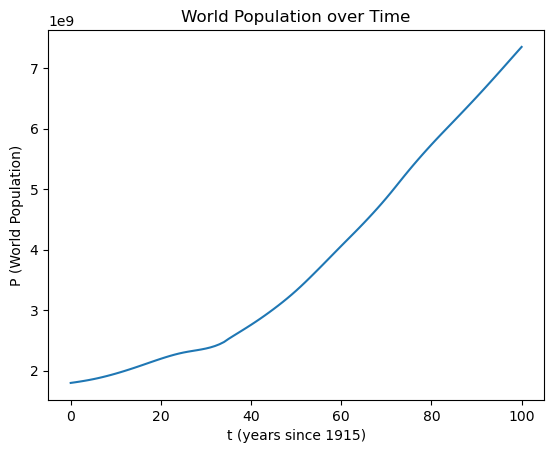

In [22]:
plt.plot(df['t'], df['P'])
plt.xlabel('t (years since 1915)')
plt.ylabel('P (World Population)')
plt.title('World Population over Time')
plt.show()

#### We now get to the business of finding 'r'

In [23]:
# Extract data from dataframe
t = df['t'].values
P = df['P'].values

# Get initial population (at t=0, year 1915)
P0 = P[0]

print(f"Initial Population (P0): {P0}")
print(f"Time range (t): {t.min()} to {t.max()} years")
print(f"Population range (P): {P.min()} to {P.max()}")

Initial Population (P0): 1798018386.0
Time range (t): 0 to 100 years
Population range (P): 1798018386.0 to 7349472099.0


In [24]:
# Define the fitness function for the genetic algorithm
def fitness_func(ga_instance, solution, solution_idx):
    """
    Fitness function to minimize the sum of squared errors (SSE)
    between observed and predicted population values.
    
    ga_instance: instance of the GA class (required by pygad)
    solution: array with one gene (r value)
    solution_idx: index of the solution
    """
    r = solution[0]
    
    # Calculate predicted population using P = P0 * e^(rt)
    P_predicted = P0 * np.exp(r * t)
    
    # Calculate sum of squared errors
    sse = np.sum((P - P_predicted) ** 2)
    
    # Return fitness (higher is better, so we invert SSE)
    fitness = 1.0 / (1.0 + sse)
    
    return fitness

In [25]:
# Configure and run the Genetic Algorithm
ga = pygad.GA(
    num_generations=100,           # Number of generations
    num_parents_mating=6,          # Number of parents for mating
    sol_per_pop=20,                # Number of solutions per population
    num_genes=1,                   # We're solving for one variable: r
    fitness_func=fitness_func,
    gene_space={"low": 0.0001, "high": 1.0},  # Search range for r (positive growth rate)
    mutation_percent_genes=15,     # Mutation percentage
    keep_elitism=2,                # Keep best solutions
    random_seed=42,
    suppress_warnings=True
)

# Run the GA
ga.run()

# Get the best solution
solution, solution_fitness, solution_idx = ga.best_solution()
r_optimal = solution[0]

print(f"\n{'='*50}")
print(f"Genetic Algorithm Results:")
print(f"{'='*50}")
print(f"Optimal r value: {r_optimal:.8f}")
print(f"Fitness score: {solution_fitness:.8f}")
print(f"\nEquation: P = {P0:.0f} * e^({r_optimal:.6f} * t)")
print(f"{'='*50}")


Genetic Algorithm Results:
Optimal r value: 0.01449205
Fitness score: 0.00000000

Equation: P = 1798018386 * e^(0.014492 * t)


In [26]:
# Calculate predicted values using optimal r
P_predicted = P0 * np.exp(r_optimal * t)

# Calculate R-squared to assess model fit
ss_res = np.sum((P - P_predicted) ** 2)
ss_tot = np.sum((P - np.mean(P)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"Model Performance:")
print(f"Sum of Squared Errors (SSE): {ss_res:.2e}")
print(f"R-squared: {r_squared:.6f}")
print(f"RMSE: {np.sqrt(ss_res / len(t)):.2e}")

Model Performance:
Sum of Squared Errors (SSE): 6.93e+18
R-squared: 0.977085
RMSE: 2.62e+08


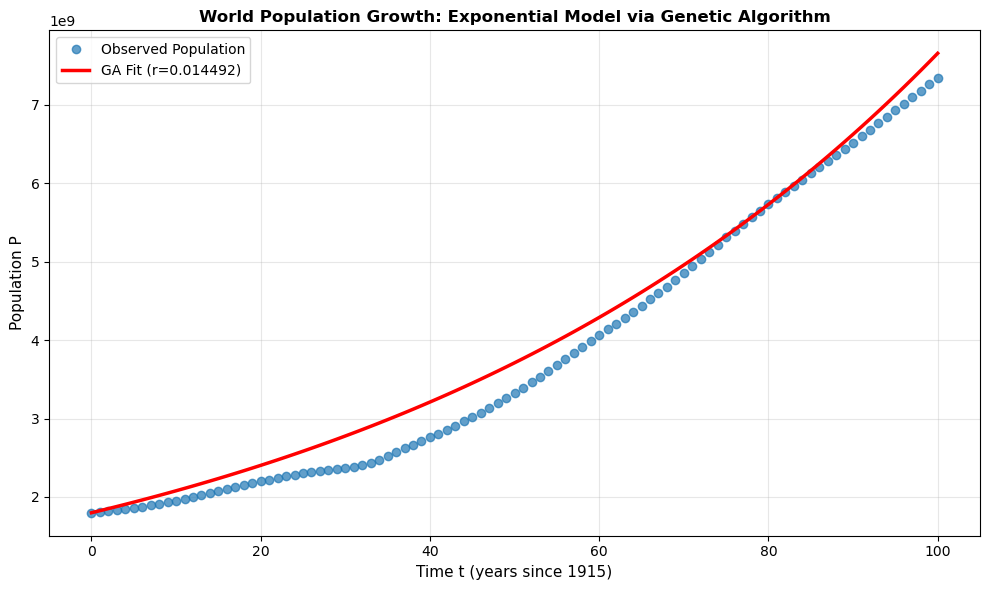

In [27]:
# Plot the results: observed vs GA-fitted model
plt.figure(figsize=(10, 6))
plt.plot(t, P, 'o', markersize=6, label='Observed Population', alpha=0.7)
plt.plot(t, P_predicted, '-', linewidth=2.5, label=f'GA Fit (r={r_optimal:.6f})', color='red')
plt.xlabel('Time t (years since 1915)', fontsize=11)
plt.ylabel('Population P', fontsize=11)
plt.title('World Population Growth: Exponential Model via Genetic Algorithm', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

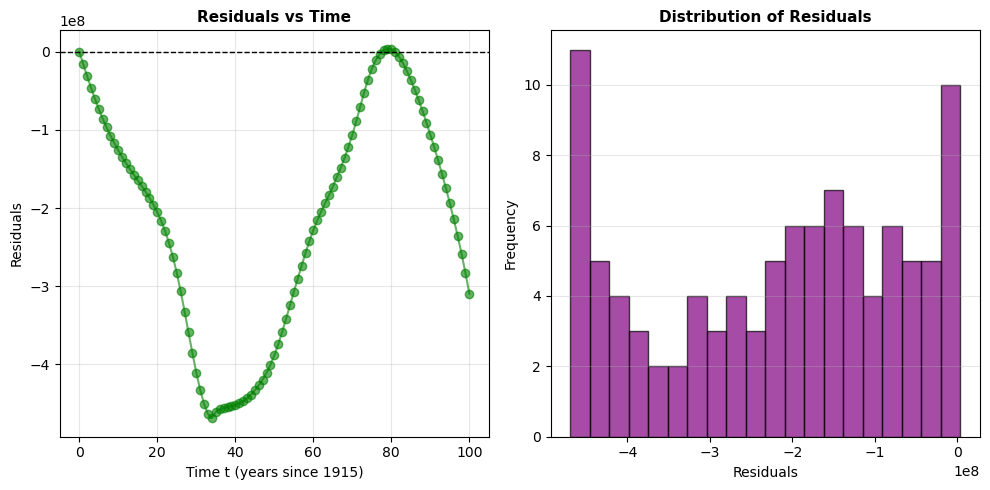

In [28]:
# Plot the residuals
residuals = P - P_predicted

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, residuals, 'o-', color='green', alpha=0.6)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Time t (years since 1915)', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.title('Residuals vs Time', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Residuals', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Distribution of Residuals', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()